In [11]:
"""
ESP32 Motor Fault Detection - Complete ML Training Pipeline
Trains a lightweight multiclass classification model for embedded deployment
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.13.1


In [12]:
# ============================================================================
# STEP 1: Load the Dataset
# ============================================================================
print("\n" + "="*70)
print("STEP 1: Loading Dataset")
print("="*70)

# Load the CSV file
df = pd.read_csv('fault.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check class distribution
print(f"\nClass distribution:")
print(df['label'].value_counts().sort_index())


STEP 1: Loading Dataset
Dataset shape: (2001, 10)

First few rows:
         ax        ay        az        gx        gy        gz       temp  \
0  0.030461 -0.004683 -0.004683  0.789606  0.383717 -0.234737  41.295377   
1  0.004839 -0.038266 -0.034498 -0.281144 -0.506416  0.157124  39.068540   
2 -0.004516  0.001351 -0.028495 -0.272191  0.055461 -0.575497  42.931298   
3 -0.012034  0.037046 -0.000270 -0.528855  0.411272 -0.610422  39.416613   
4  0.003937  0.014769  0.003427 -0.057824 -0.150552 -0.739261  37.343628   

    current          rpm  label  
0  1.972347  1514.901425      0  
1  1.907316  1516.276801      0  
2  1.717539  1472.759278      0  
3  1.879872  1511.270941      0  
4  1.608066  1506.265908      0  

Missing values:
ax         0
ay         0
az         0
gx         0
gy         0
gz         0
temp       0
current    0
rpm        0
label      0
dtype: int64

Class distribution:
label
0    800
1    200
2    200
3    200
4    200
5    200
6    201
Name: count, dtype: i

In [13]:
# ============================================================================
# STEP 2: Separate Features and Labels
# ============================================================================
print("\n" + "="*70)
print("STEP 2: Separating Features and Labels")
print("="*70)

# Features: ax, ay, az, gx, gy, gz, temp, current, rpm
X = df[['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'temp', 'current', 'rpm']].values

# Labels: 0-6 (7 classes)
y = df['label'].values

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")


STEP 2: Separating Features and Labels
Features shape: (2001, 9)
Labels shape: (2001,)
Number of classes: 7
Classes: [0 1 2 3 4 5 6]


In [14]:
# ============================================================================
# STEP 3: Normalize Features
# ============================================================================
print("\n" + "="*70)
print("STEP 3: Normalizing Features")
print("="*70)

# Use StandardScaler for normalization (better for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original data range - Min: {X.min():.2f}, Max: {X.max():.2f}")
print(f"Scaled data range - Min: {X_scaled.min():.2f}, Max: {X_scaled.max():.2f}")

# Save the scaler for later use in ESP32 deployment
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nScaler saved as 'scaler.pkl'")


STEP 3: Normalizing Features
Original data range - Min: -8.07, Max: 1592.95
Scaled data range - Min: -6.60, Max: 4.93

Scaler saved as 'scaler.pkl'


In [16]:
# ============================================================================
# STEP 5: Build ESP32-Friendly Model
# ============================================================================
print("\n" + "="*70)
print("STEP 5: Building Lightweight Neural Network")
print("="*70)

# Build a small, efficient model suitable for ESP32
model = keras.Sequential([
    keras.layers.Input(shape=(9,)),  # 9 input features
    keras.layers.Dense(32, activation='relu'),  # Small hidden layer
    keras.layers.Dropout(0.3),  # Prevent overfitting
    keras.layers.Dense(16, activation='relu'),  # Even smaller layer
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax')  # 7 output classes
])

# Compile with sparse categorical crossentropy (labels are integers)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()



STEP 5: Building Lightweight Neural Network

Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                320       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 7)                 119       
                                                                 
Total params: 967 (3.78 KB)
Trainable params: 967 (3.78 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [17]:
# ============================================================================
# STEP 6: Train the Model
# ============================================================================
print("\n" + "="*70)
print("STEP 6: Training Model")
print("="*70)

# Train with early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the trained model
model.save('motor_fault_model.h5')
print("\nModel saved as 'motor_fault_model.h5'")


STEP 6: Training Model
Epoch 1/100
40/40 [==============================] - 1s 7ms/step - loss: 1.8382 - accuracy: 0.3438 - val_loss: 1.5652 - val_accuracy: 0.5781
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 1.5483 - accuracy: 0.5672 - val_loss: 1.3271 - val_accuracy: 0.5969
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 1.3240 - accuracy: 0.6047 - val_loss: 1.1442 - val_accuracy: 0.6219
Epoch 4/100
40/40 [==============================] - 0s 3ms/step - loss: 1.1659 - accuracy: 0.6203 - val_loss: 1.0086 - val_accuracy: 0.6469
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 1.0731 - accuracy: 0.6547 - val_loss: 0.8842 - val_accuracy: 0.6906
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.9774 - accuracy: 0.6930 - val_loss: 0.7828 - val_accuracy: 0.7375
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.8683 - accuracy: 0.7289 - val_loss: 0.6979 - val_accura

/home/mariam/NTI/analysis/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



STEP 7: Model Evaluation
13/13 [==============================] - 0s 2ms/step

Test Accuracy: 94.76%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       161
   Imbalance       0.83      0.72      0.77        40
Misalignment       0.87      0.97      0.92        40
     Bearing       1.00      0.88      0.93        40
   Looseness       0.91      0.97      0.94        40
    Overload       1.00      1.00      1.00        40
    Overheat       1.00      1.00      1.00        40

    accuracy                           0.95       401
   macro avg       0.94      0.93      0.93       401
weighted avg       0.95      0.95      0.95       401


Confusion Matrix:
[[158   3   0   0   0   0   0]
 [  3  29   5   0   3   0   0]
 [  1   0  39   0   0   0   0]
 [  1   2   1  35   1   0   0]
 [  0   1   0   0  39   0   0]
 [  0   0   0   0   0  40   0]
 [  0   0   0   0   0   0  40]]

Confusion matrix saved as 'confusion_ma

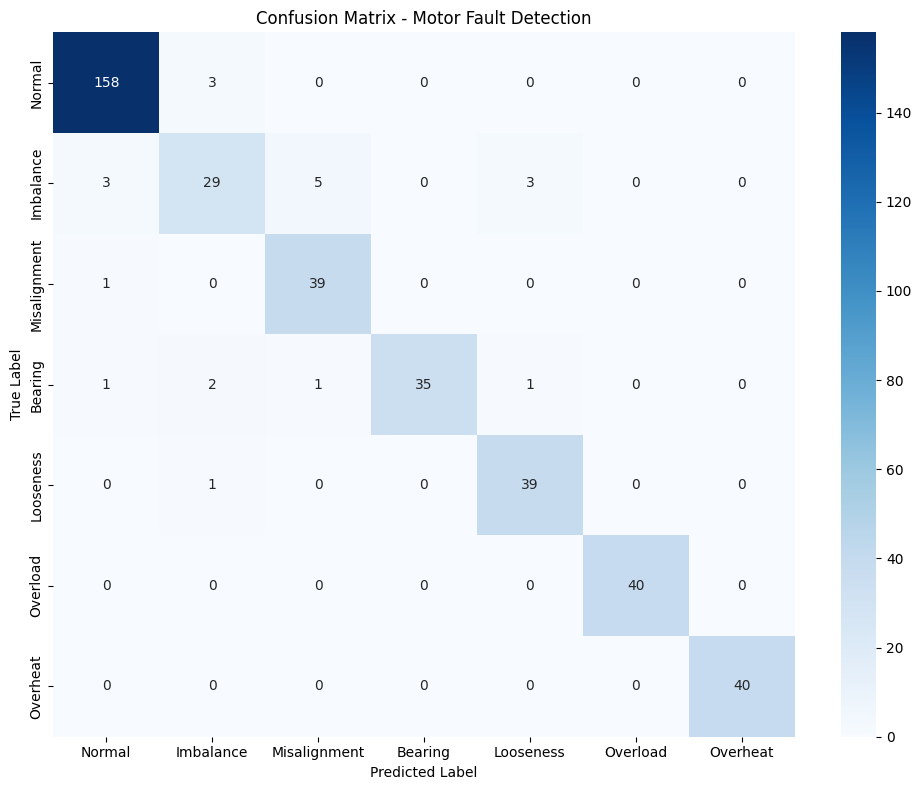

In [18]:
# ============================================================================
# STEP 7: Evaluate the Model
# ============================================================================
print("\n" + "="*70)
print("STEP 7: Model Evaluation")
print("="*70)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# Classification report
class_names = ['Normal', 'Imbalance', 'Misalignment', 'Bearing', 
               'Looseness', 'Overload', 'Overheat']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Motor Fault Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved as 'confusion_matrix.png'")

In [19]:
# ============================================================================
# STEP 8: Convert to TensorFlow Lite
# ============================================================================
print("\n" + "="*70)
print("STEP 8: Converting to TensorFlow Lite")
print("="*70)

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the basic TFLite model
with open('motor_fault_model.tflite', 'wb') as f:
    f.write(tflite_model)

basic_size = len(tflite_model) / 1024
print(f"Basic TFLite model size: {basic_size:.2f} KB")



STEP 8: Converting to TensorFlow Lite
INFO:tensorflow:Assets written to: /tmp/tmp10x0wiaj/assets


INFO:tensorflow:Assets written to: /tmp/tmp10x0wiaj/assets


Basic TFLite model size: 5.86 KB


2026-01-04 15:19:14.952063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2026-01-04 15:19:14.952101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-01-04 15:19:14.952342: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp10x0wiaj
2026-01-04 15:19:14.953628: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2026-01-04 15:19:14.953656: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp10x0wiaj
2026-01-04 15:19:14.958013: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2026-01-04 15:19:15.002286: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp10x0wiaj
2026-01-04 15:19:15.016021: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 63679 m

In [20]:
# ============================================================================
# STEP 9: Apply INT8 Quantization
# ============================================================================
print("\n" + "="*70)
print("STEP 9: Applying INT8 Quantization for ESP32")
print("="*70)

# Representative dataset generator for quantization
def representative_dataset():
    for i in range(min(100, len(X_train))):
        yield [X_train[i:i+1].astype(np.float32)]

# Convert with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quantized_model = converter.convert()

# Save the quantized model
with open('motor_fault_model_quantized.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

quantized_size = len(tflite_quantized_model) / 1024
print(f"Quantized TFLite model size: {quantized_size:.2f} KB")
print(f"Size reduction: {(1 - quantized_size/basic_size)*100:.1f}%")

if quantized_size < 200:
    print(f"✓ Model meets ESP32 constraint (<200 KB)")
else:
    print(f"⚠ Warning: Model exceeds 200 KB target")



STEP 9: Applying INT8 Quantization for ESP32
INFO:tensorflow:Assets written to: /tmp/tmpot3vyhwg/assets


INFO:tensorflow:Assets written to: /tmp/tmpot3vyhwg/assets


Quantized TFLite model size: 3.56 KB
Size reduction: 39.2%
✓ Model meets ESP32 constraint (<200 KB)


/home/mariam/NTI/analysis/myenv/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2026-01-04 15:19:30.224778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2026-01-04 15:19:30.224823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-01-04 15:19:30.225077: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpot3vyhwg
2026-01-04 15:19:30.226400: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2026-01-04 15:19:30.226440: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpot3vyhwg
2026-01-04 15:19:30.231036: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2026-01-04 15:19:30.283333: I tensorflow/cc/saved_model/loader.cc:215]

In [21]:
# ============================================================================
# STEP 10: Test TFLite Inference
# ============================================================================
print("\n" + "="*70)
print("STEP 10: Testing TFLite Inference on Single Sample")
print("="*70)

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='motor_fault_model_quantized.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nInput details:")
print(f"  Shape: {input_details[0]['shape']}")
print(f"  Type: {input_details[0]['dtype']}")

print("\nOutput details:")
print(f"  Shape: {output_details[0]['shape']}")
print(f"  Type: {output_details[0]['dtype']}")

# Test with a single sample from test set
test_sample = X_test[0:1].astype(np.float32)

# For quantized model, we need to quantize the input
input_scale, input_zero_point = input_details[0]['quantization']
test_sample_quantized = (test_sample / input_scale + input_zero_point).astype(np.int8)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], test_sample_quantized)

# Run inference
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Dequantize output if needed
output_scale, output_zero_point = output_details[0]['quantization']
output_dequantized = (output_data.astype(np.float32) - output_zero_point) * output_scale

# Get predicted class
predicted_class = np.argmax(output_dequantized)
true_class = y_test[0]

print(f"\nInference Test:")
print(f"  True label: {true_class} ({class_names[true_class]})")
print(f"  Predicted label: {predicted_class} ({class_names[predicted_class]})")
print(f"  Confidence: {np.max(output_dequantized)*100:.2f}%")
print(f"  Match: {'✓' if predicted_class == true_class else '✗'}")




STEP 10: Testing TFLite Inference on Single Sample

Input details:
  Shape: [1 9]
  Type: <class 'numpy.int8'>

Output details:
  Shape: [1 7]
  Type: <class 'numpy.int8'>

Inference Test:
  True label: 0 (Normal)
  Predicted label: 0 (Normal)
  Confidence: 99.22%
  Match: ✓


In [22]:
# ============================================================================
# STEP 11: ESP32 Deployment Information
# ============================================================================
print("\n" + "="*70)
print("ESP32 DEPLOYMENT GUIDE")
print("="*70)

print("""
Files needed for ESP32:
  1. motor_fault_model_quantized.tflite - Deploy this on ESP32
  2. scaler.pkl - Extract mean/std values for preprocessing

Scaler parameters (for ESP32 preprocessing):
""")

print("Mean values:", scaler.mean_)
print("Std values:", scaler.scale_)

print("""
\nESP32 Inference Steps:
  1. Read sensor data: [ax, ay, az, gx, gy, gz, temp, current, rpm]
  2. Normalize: normalized = (raw - mean) / std
  3. Quantize input: quantized = normalized / input_scale + input_zero_point
  4. Run TFLite inference
  5. Dequantize output: output = (quantized - zero_point) * scale
  6. Get predicted class: argmax(output)

Example C++ pseudocode for ESP32:
  
  float input[9] = {ax, ay, az, gx, gy, gz, temp, current, rpm};
  
  // Normalize
  for(int i=0; i<9; i++) {
    input[i] = (input[i] - mean[i]) / std[i];
  }
  
  // Quantize and run inference
  // (TFLite Micro handles this automatically)
  
  int predicted_class = argmax(output);
  
  // Map to fault type
  const char* faults[] = {"Normal", "Imbalance", "Misalignment", 
                          "Bearing", "Looseness", "Overload", "Overheat"};
  Serial.println(faults[predicted_class]);
""")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"\nFinal Model Performance:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Model Size: {quantized_size:.2f} KB")
print(f"  Ready for ESP32: {'Yes' if quantized_size < 200 else 'No'}")
print("\nGenerated files:")
print("  - motor_fault_model.h5")
print("  - motor_fault_model.tflite")
print("  - motor_fault_model_quantized.tflite (USE THIS ON ESP32)")
print("  - scaler.pkl")
print("  - confusion_matrix.png")


ESP32 DEPLOYMENT GUIDE

Files needed for ESP32:
  1. motor_fault_model_quantized.tflite - Deploy this on ESP32
  2. scaler.pkl - Extract mean/std values for preprocessing

Scaler parameters (for ESP32 preprocessing):

Mean values: [5.99141163e-02 4.68072370e-02 4.21709463e-02 2.77288616e-01
 2.62001281e-01 2.81187325e-01 4.34209505e+01 2.16994154e+00
 1.47602631e+03]
Std values: [ 0.12853713  0.1281364   0.12954736  1.33143455  1.31496109  1.33515316
  6.59782181  0.43492526 58.00813606]


ESP32 Inference Steps:
  1. Read sensor data: [ax, ay, az, gx, gy, gz, temp, current, rpm]
  2. Normalize: normalized = (raw - mean) / std
  3. Quantize input: quantized = normalized / input_scale + input_zero_point
  4. Run TFLite inference
  5. Dequantize output: output = (quantized - zero_point) * scale
  6. Get predicted class: argmax(output)

Example C++ pseudocode for ESP32:
  
  float input[9] = {ax, ay, az, gx, gy, gz, temp, current, rpm};
  
  // Normalize
  for(int i=0; i<9; i++) {
    inp